In [2]:
# import wget
import os
import glob
import random
import numpy as np
import os,shutil
import matplotlib 
import matplotlib.pyplot as plt
from PIL import Image
from skimage.io import imread
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from os import listdir
from torch.utils.data import Dataset
from skimage.transform import resize
from IPython.display import clear_output
import torchvision
import torchvision.transforms as transforms

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
newdir = '/content/drive/My Drive/Colab Notebooks'

mydir = newdir+'/Raw Dataset'
pathDir =  os.listdir(mydir)  


Load and speperate the datas


In [0]:
# separate dataset to 3 class : testA, test B, train and its masks.
testsetA = []
testsetB = []
trainset = []
testmaskA = []
testmaskB = []
trainmask = []

for allDir in pathDir:      
    if allDir.startswith('testA')==True and allDir.endswith('anno.bmp')==True:     

        testmaskA.append(allDir)
        
    if allDir.startswith('testA')==True and allDir.endswith('anno.bmp')==False:
  
        testsetA.append(allDir)

    if allDir.startswith('testB')==True and allDir.endswith('anno.bmp')==True:
       
        testmaskB.append(allDir)

    if allDir.startswith('testB')==True and allDir.endswith('anno.bmp')==False:

        testsetB.append(allDir)

    if allDir.startswith('train')==True and allDir.endswith('anno.bmp')==True:
        
        trainmask.append(allDir)

    if allDir.startswith('train')==True and allDir.endswith('anno.bmp')==False:
        
        trainset.append(allDir)

#Build new dataset root  

raw_img_train_location = newdir+os.sep+'train'+os.sep+'raw'
raw_img_testA_location = newdir+os.sep+'testA'+os.sep+'raw'
raw_img_testB_location = newdir+os.sep+'testB'+os.sep+'raw'
anno_img_train_location = newdir+os.sep+'train'+os.sep+'anno'
anno_img_testA_location = newdir+os.sep+'testA'+os.sep+'anno'
anno_img_testB_location = newdir+os.sep+'testB'+os.sep+'anno'


if not os.path.isdir(raw_img_train_location):
    os.makedirs(raw_img_train_location)
if not os.path.isdir(raw_img_testA_location):
    os.makedirs(raw_img_testA_location)
if not os.path.isdir(raw_img_testB_location):
    os.makedirs(raw_img_testB_location)

if not os.path.isdir(anno_img_train_location):
    os.makedirs(anno_img_train_location)
if not os.path.isdir(anno_img_testA_location):
    os.makedirs(anno_img_testA_location)
if not os.path.isdir(anno_img_testB_location):
    os.makedirs(anno_img_testB_location)

def copy_img(path,list):
    for i in range(len(list)):
        new_obj_name = list[i]
        shutil.copy(mydir+'/'+new_obj_name,path+'/'+new_obj_name)

copy_img(raw_img_train_location,trainset)
copy_img(raw_img_testA_location,testsetA) 
copy_img(raw_img_testB_location,testsetB)
copy_img(anno_img_train_location,trainmask)
copy_img(anno_img_testA_location,testmaskA)
copy_img(anno_img_testB_location,testmaskB)
    
    

In [0]:
# sort the dataset to make raw images and its masks are corresponding.

def namesort(path,way):
    # 0 for raw, 1 for anno
    labelList = []  # 类标签列表
    datasetList = listdir(path)
    datasetload = []
    if way==0:
        list.sort(datasetList,key=lambda x: int(x[6:-4]))
    else:
        list.sort(datasetList,key=lambda x: int(x[6:-9]))
    for i in range(len(datasetList)):
        temp=imread(path+"/"+datasetList[i])
        datasetload.append(temp)
    return datasetList,datasetload

(testsetA,testsetAraw) = namesort(raw_img_testA_location,0)
(testmaskA,testmaskAanno) = namesort(anno_img_testA_location,1)
(testsetB,testsetBraw) = namesort(raw_img_testB_location,0)
(testmaskB,testmaskBanno) = namesort(anno_img_testB_location,1)
(trainset,trainsetraw) = namesort(raw_img_train_location,0)
(trainmask,trainmaskanno) = namesort(anno_img_train_location,1)




Crop the images for argumentaion

In [0]:
from skimage.transform import resize
size = (400,400)
X = [resize(x,size,mode='constant',anti_aliasing=True) for x in testsetAraw]
Y = [resize(y,size,mode='constant',anti_aliasing=False) > 0.5 for y in testmaskAanno]
Z = [resize(z,size,mode='constant',anti_aliasing=True) for z in testsetBraw]
P = [resize(p,size,mode='constant',anti_aliasing=False) > 0.5 for p in testmaskBanno]


In [0]:
raw_img_train_cropped_location = newdir+os.sep+'train'+os.sep+'cropped'+os.sep+'raw'

anno_img_train_cropped_location = newdir+os.sep+'train'+os.sep+'cropped'+os.sep+'anno'



if not os.path.isdir(raw_img_train_cropped_location):
    os.makedirs(raw_img_train_cropped_location)

if not os.path.isdir(anno_img_train_cropped_location):
    os.makedirs(anno_img_train_cropped_location)

def crop_img(raw_picture,anno_picture,crop_size):
    ##raw_picture：raw images, anno_picture:anno images，path1:raw path，path2:anno path
    cropped_raw_result = []
    cropped_anno_result = []
#      for i in range(len(raw_picture)):
    for j in range(2):
        raw_img = raw_picture
        anno_img = anno_picture
        x_shape = raw_img.shape[0]-crop_size
        y_shape = raw_img.shape[1]-crop_size
        x1 = random.randint(0,int(x_shape/2))
        x2 = random.randint(int(x_shape/2),x_shape)
        y1 = random.randint(0,int(y_shape/2))
        y2 = random.randint(int(y_shape/2),y_shape)
        if j == 0:
            cropped_raw_img = raw_img[x1:x1+crop_size,:]
            cropped_raw_img = cropped_raw_img[:,y1:y1+crop_size]
            cropped_anno_img = anno_img[x1:x1+crop_size,:]
            cropped_anno_img = cropped_anno_img[:,y1:y1+crop_size]
        else:
            cropped_raw_img = raw_img[x2:x2+crop_size,:]
            cropped_raw_img = cropped_raw_img[:,y2:y2+crop_size]
            cropped_anno_img = anno_img[x2:x2+crop_size,:]
            cropped_anno_img = cropped_anno_img[:,y2:y2+crop_size]
        if cropped_anno_img.shape[0]!=400 or cropped_anno_img.shape[1]!=400:
            print('error')
        cropped_raw_result.append(cropped_raw_img)
        cropped_anno_result.append(cropped_anno_img)
 
    
    return cropped_raw_result,cropped_anno_result 


In [9]:
#IMAGE AUGMENTATION 
transform = transforms.Compose(
    [transforms.ToTensor()]
)



def batch_generator(type,img_list, anno_list, batch_size, num_of_classes=2,transform=transform):
    images=[]
    annos=[]
    

    if type=="train":
        for i in range(batch_size):
            rand_int = int(np.random.choice(len(img_list)-1,size=1,replace=False))
            img =  np.array(Image.open(path_to_images+os.sep+img_list[rand_int]))
            anno = np.array(Image.open(path_to_annotations+os.sep+anno_list[rand_int]).convert("L"))
            image_crop,anno_crop=crop_img(img,anno,400)
           # image=np.array(image_crop)
            image_crop1=transform(image_crop[0])
            image1=np.array(image_crop1)
            image_crop2=transform(image_crop[1])
            image2=np.array(image_crop2)
            images.append(image1)
            images.append(image2)
          #  print(len(images))
          

            for i in range(2):
                anno_crop[i] = np.array(anno_crop[i])
           #     print(anno_crop[i].shape)
                anno_crop[i][anno_crop[i]>0] = 1
              #  print(anno_crop[i])
                anno_reshaped = np.zeros((400,400, num_of_classes))
                for j in range(num_of_classes):
                    anno_reshaped[:, :, j][anno_crop[i] == j] = 1
                
                annos.append(anno_reshaped)
    
    images=np.array(images)
    annos=np.array(annos)

    if(type=="test"):
        image_temp=[]
        annos_temp=[]
        for i in range(batch_size):
            rand_int = int(np.random.choice(len(img_list)-1,size=1,replace=False))
            img =  img_list[rand_int]
            anno = anno_list[rand_int]
            image_temp.append(img)
            anno[anno>0] = 1
            anno_reshaped = np.zeros((anno.shape[0], anno.shape[1], num_of_classes))
        #    print(anno_reshaped.shape)
        #data aug
        
            for i in range(num_of_classes):

                anno_reshaped[:, :, i][anno == i] = 1
        
           # annos.append(anno_reshaped)
            annos_temp.append(anno_reshaped)
        
        
        images=np.array(image_temp)
        annos=np.array(annos_temp)  
      #  annos.shape=annos.shape+(1,)  
    return images, annos
    
    

path_to_images = newdir+'/train/raw'
path_to_annotations = newdir+'/train/anno'



batch_size = 6
train_image, train_annos = batch_generator('train',trainset,trainmask,batch_size,2,transform)


print(train_image.shape)
print(train_annos.shape)
print(train_image.dtype)

(12, 3, 400, 400)
(12, 400, 400, 2)
float32


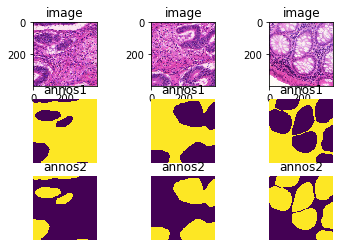

In [10]:
imtest = torch.from_numpy(train_image)

annos = torch.from_numpy(train_annos)


for k in range(3):
    
    imshow = imtest.permute(0,2,3,1)
    plt.subplot(3, 3, k+1)
    plt.imshow(imshow[k,:,:,:])
    plt.title('image')
    plt.subplot(3, 3, k+4)
    plt.imshow(annos[k,:,:,0])
    plt.title('annos1')
    plt.axis('off')
    plt.subplot(3, 3, k+7)
    plt.imshow(annos[k,:,:,1])
    plt.title('annos2')
    plt.axis('off')

In [0]:
path_to_testA = newdir+'/testA/raw'
path_to_annoA = newdir+'/testA/anno'
path_to_testB = newdir+'/testB/raw'
path_to_annoB = newdir+'/testB/anno'

(testsetA,testsetAraw) = namesort(path_to_testA,0)
(testmaskA,testmaskAanno) = namesort(path_to_annoA,1)
(testsetB,testsetBraw) = namesort(path_to_testB,0)
(testmaskB,testmaskBanno) = namesort(path_to_annoB,1)

for i in range(len(testsetA)):
    testsetA[i]=path_to_testA+os.sep+testsetA[i]

for i in range(len(testmaskA)):
    testmaskA[i]=path_to_annoA+os.sep+testmaskA[i]

In [0]:
size = (400,400)
X = [resize(x,size,mode='constant',anti_aliasing=True) for x in testsetAraw]
Y = [resize(y,size,mode='constant',anti_aliasing=False) for y in testmaskAanno]
testB_iXmage = [resize(z,size,mode='constant',anti_aliasing=True) for z in testsetBraw]
testB_anno = [resize(p,size,mode='constant',anti_aliasing=False) for p in testmaskBanno]

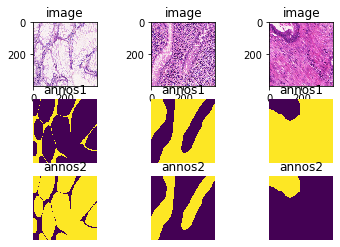

In [13]:
test_img, test_anno = batch_generator("test",X,Y,batch_size,2,transform)

for k in range(3):
    
    imshow = test_img
    annos=test_anno
    plt.subplot(3, 3, k+1)
    plt.imshow(imshow[k,:,:,:])
    plt.title('image')
    plt.subplot(3, 3, k+4)
    plt.imshow(annos[k,:,:,0])
    plt.title('annos1')
    plt.axis('off')
    plt.subplot(3, 3, k+7)
    plt.imshow(annos[k,:,:,1])
    plt.title('annos2')
    plt.axis('off')

Define the network


In [0]:

class SegNetBasic(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn0=nn.BatchNorm2d(64)
        self.pool0 = nn.MaxPool2d(3, 2, padding=1)  # 256 -> 128
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn1=nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(3, 2, padding=1)  # 128 -> 64
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn2=nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(3, 2, padding=1)  # 64 -> 32
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn3=nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(3, 2, padding=1)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(32)  # 16 -> 32
        self.dec_conv0 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn_dec0=nn.BatchNorm2d(64)
        self.upsample1 = nn.Upsample(64)  # 32 -> 64
        self.dec_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn_dec1=nn.BatchNorm2d(64)
        self.upsample2 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn_dec2=nn.BatchNorm2d(64)
        self.upsample3 = nn.Upsample(400)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(64, 2, 3, padding=1)
        self.bn_dec3=nn.BatchNorm2d(64)
    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.bn0(self.enc_conv0(x))))
        e1 = self.pool1(F.relu(self.bn1(self.enc_conv1(e0))))
        e2 = self.pool2(F.relu(self.bn2(self.enc_conv2(e1))))
        e3 = self.pool3(F.relu(self.bn3(self.enc_conv3(e2))))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 = F.relu(self.dec_conv0(self.bn_dec0(self.upsample0(b))))
        d1 = F.relu(self.dec_conv1(self.bn_dec1(self.upsample1(d0))))
        d2 = F.relu(self.dec_conv2(self.bn_dec2(self.upsample2(d1))))
        d3 = self.dec_conv3(self.bn_dec3(self.upsample3(d2)) ) # no activation
        d3 = torch.softmax(d3,dim=1)
        return d3
    
    

In [0]:
class SegNet(nn.Module):
    
    def __init__(self, input_channels, output_channels):
        super(SegNet, self).__init__()
        
        self.input_channels = input_channels # number of bands in the image data
        self.output_channels = output_channels # number classes
        
        # Encoder conv layers: The encoder corresponds to the first 13 conv layers of the VGG16 architecture 
        self.conv11 = nn.Conv2d(self.input_channels, 64, kernel_size = 3, padding = 1)
        self.conv12 = nn.Conv2d(64, 64, kernel_size = 3, padding = 1)
        self.conv21 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
        self.conv22 = nn.Conv2d(128, 128, kernel_size = 3, padding = 1)
        self.conv31 = nn.Conv2d(128, 256, kernel_size = 3, padding = 1)
        self.conv32 = nn.Conv2d(256, 256, kernel_size = 3, padding = 1)
        self.conv33 = nn.Conv2d(256, 256, kernel_size = 3, padding = 1)
        self.conv41 = nn.Conv2d(256, 512, kernel_size = 3, padding = 1)
        self.conv42 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1)
        self.conv43 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1)
        self.conv51 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1)
        self.conv52 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1)
        self.conv53 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1)
        
        # Encoder pooling layers
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices = True)
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices = True)
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices = True)
        self.pool4 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices = True)
        self.pool5 = nn.MaxPool2d(kernel_size = 2, stride = 2, return_indices = True)
        
        # Decoder conv layers
        self.deconv51 = nn.ConvTranspose2d(512, 512, kernel_size = 3, padding = 1)
        self.deconv52 = nn.ConvTranspose2d(512, 512, kernel_size = 3, padding = 1)
        self.deconv53 = nn.ConvTranspose2d(512, 512, kernel_size = 3, padding = 1)
        self.deconv41 = nn.ConvTranspose2d(512, 512, kernel_size = 3, padding = 1)
        self.deconv42 = nn.ConvTranspose2d(512, 512, kernel_size = 3, padding = 1)
        self.deconv43 = nn.ConvTranspose2d(512, 256, kernel_size = 3, padding = 1)
        self.deconv31 = nn.ConvTranspose2d(256, 256, kernel_size = 3, padding = 1)
        self.deconv32 = nn.ConvTranspose2d(256, 256, kernel_size = 3, padding = 1)
        self.deconv33 = nn.ConvTranspose2d(256, 128, kernel_size = 3, padding = 1)
        self.deconv21 = nn.ConvTranspose2d(128, 128, kernel_size = 3, padding = 1)
        self.deconv22 = nn.ConvTranspose2d(128, 64, kernel_size = 3, padding = 1)
        self.deconv11 = nn.ConvTranspose2d(64, 64, kernel_size = 3, padding = 1)
        self.deconv12 = nn.ConvTranspose2d(64 , self.output_channels, kernel_size = 3, padding = 1)
        
        # Decoder unpooling layers
        self.unpool5 = nn.MaxUnpool2d(kernel_size = 2, stride = 2)
        self.unpool4 = nn.MaxUnpool2d(kernel_size = 2, stride = 2)
        self.unpool3 = nn.MaxUnpool2d(kernel_size = 2, stride = 2)
        self.unpool2 = nn.MaxUnpool2d(kernel_size = 2, stride = 2)
        self.unpool1 = nn.MaxUnpool2d(kernel_size = 2, stride = 2)
        
        # Batchnorm is used as regularization
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.batch_norm3 = nn.BatchNorm2d(256)
        self.batch_norm4 = nn.BatchNorm2d(512)
        
    def forward(self, img):
        """
        Forward pass the input img through the network
        """
        
        # Encoder layer 1:
        dim1 = img.size()
        img = self.conv11(img)
        img = self.batch_norm1(img)
        img = F.relu(img)
        img = self.conv12(img)
        img = self.batch_norm1(img)
        img = F.relu(img)
        img, idxs1 = self.pool1(img)
        
        # Encoder layer 2:
        dim2 = img.size()
        img = self.conv21(img)
        img = self.batch_norm2(img)
        img = F.relu(img)
        img = self.conv22(img)
        img = self.batch_norm2(img)
        img = F.relu(img)
        img, idxs2 = self.pool2(img)
        
        # Encoder layer 3
        dim3 = img.size()
        img = self.conv31(img)
        img = self.batch_norm3(img)
        img = F.relu(img)
        img = self.conv32(img)
        img = self.batch_norm3(img)
        img = F.relu(img)
        img = self.conv33(img)
        img = self.batch_norm3(img)
        img = F.relu(img)
        img, idxs3 = self.pool3(img)
        
        # Encoder layer 4
        dim4 = img.size()
        img = self.conv41(img)
        img = self.batch_norm4(img)
        img = F.relu(img)
        img = self.conv42(img)
        img = self.batch_norm4(img)
        img = F.relu(img)
        img = self.conv43(img)
        img = self.batch_norm4(img)
        img = F.relu(img)
        img, idxs4 = self.pool4(img)
        
        # Encoder layer 5
        dim5 = img.size()
        img = self.conv51(img)
        img = self.batch_norm4(img)
        img = F.relu(img)
        img = self.conv52(img)
        img = self.batch_norm4(img)
        img = F.relu(img)
        img = self.conv53(img)
        img = self.batch_norm4(img)
        img = F.relu(img)
        img, idxs5 = self.pool5(img)
        
        # Decoder layer 5
        img = self.unpool5(img, idxs5, output_size = dim5)
        img = self.deconv51(img)
        img = self.batch_norm4(img)
        img = F.relu(img)
        img = self.deconv52(img)
        img = self.batch_norm4(img)
        img = F.relu(img)
        img = self.deconv53(img)
        img = self.batch_norm4(img)
        img = F.relu(img)
        
        # Decoder layer 4
        img = self.unpool4(img, idxs4, output_size = dim4)
        img = self.deconv41(img)
        img = self.batch_norm4(img)
        img = F.relu(img)
        img = self.deconv42(img)
        img = self.batch_norm4(img)
        img = F.relu(img)
        img = self.deconv43(img)
        img = self.batch_norm3(img)
        img = F.relu(img)
        
        # Decoder layer 3
        img = self.unpool3(img, idxs3, output_size = dim3)
        img = self.deconv31(img)
        img = self.batch_norm3(img)
        img = F.relu(img)
        img = self.deconv32(img)
        img = self.batch_norm3(img)
        img = F.relu(img)
        img = self.deconv33(img)
        img = self.batch_norm2(img)
        img = F.relu(img)
        
        # Decoder layer 2
        img = self.unpool2(img, idxs2, output_size = dim2)
        img = self.deconv21(img)
        img = self.batch_norm2(img)
        img = F.relu(img)
        img = self.deconv22(img)
        img = self.batch_norm1(img)
        img = F.relu(img)
        
        # Decoder layer 2
        img = self.unpool1(img, idxs1, output_size = dim1)
        img = self.deconv11(img)
        img = self.batch_norm1(img)
        img = F.relu(img)
        img = self.deconv12(img)
        
        return F.softmax(img, dim=1)

In [0]:
net=SegNetBasic()

input_channels = 3
output_channels = 2

#net = SegNet(input_channels, output_channels)

In [16]:
import torch.optim as optim

criterion = nn.BCELoss() 

optimizer = optim.Adam(net.parameters(), lr=0.001)

#def bce_loss(y_real, y_pred):
#    return torch.mean(y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred)))
print(net.parameters())

<generator object Module.parameters at 0x7f661b16f7d8>


 -- loss: 0.792161


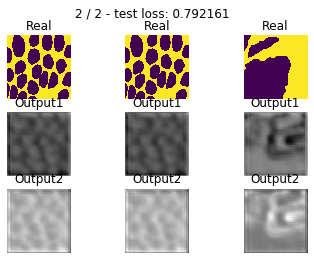

Finished


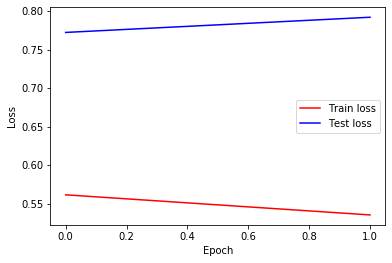

In [19]:
num_epoch = 2
steps = 5
steps_test = 5
train_loss=[]
test_loss=[]
train_loss_store=[]

for epoch in range(num_epoch):  
    
    train_loss_run = 0.0
    train_loss_avg=0.0
    print('* Epoch %d/%d' % (epoch+1, num_epoch))
    net.train()
    
    for step in range(steps):
        train_image, train_annos = batch_generator("train",trainset,trainmask,batch_size,2,transform)
        images = torch.from_numpy(train_image)
        annos_train = torch.from_numpy(train_annos)
        annos_train = annos_train.float()
        annos_train = annos_train.permute(0,3,1,2)
        optimizer.zero_grad()
        out_train = net(images)
        train_loss = criterion(out_train, annos_train)
        train_loss.backward()
        optimizer.step()
        train_loss_run += train_loss
        if step < 85:   
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, step + 1, train_loss_run / batch_size))
        train_loss_run = 0.0  
        clear_output(wait=True)
        train_loss_avg += train_loss

    train_loss_avg = train_loss_avg/steps

    train_loss_avg.detach().numpy()

    train_loss_store.append(train_loss_avg)
    print(' -- Train loss: %f' % train_loss_avg)

    net.eval()
    running_testloss=0.0
    avg_testloss=0.0
    for step in range(steps_test):
        test_image, test_annos = batch_generator("test",X,Y,batch_size,2,transform)
        inputs = torch.from_numpy(test_image)
        annos_test = torch.from_numpy(test_annos)
        inputs=inputs.permute(0,3,2,1)
        annos_test=annos_test.permute(0,3,2,1)
        inputs = inputs.float()
        annos_test = annos_test.float()
        out_test=net(inputs)
        net.zero_grad()
        loss = criterion(out_test, annos_test)
        running_testloss += loss
        if step < steps_test:   
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, step + 1, running_testloss))
        running_testloss = 0.0

        clear_output(wait=True)
        avg_testloss += loss

    avg_testloss =avg_testloss/steps
    avg_testloss.detach().numpy() 
    test_loss.append(avg_testloss)
    print(' -- loss: %f' % avg_testloss) 

    Y_hat = out_test.detach().cpu()

    imshow=test_annos
    outshow=Y_hat.permute(0,2,3,1)
    for k in range(3):
        plt.subplot(3, 3, k+1)
        plt.imshow(imshow[k,:,:,0])
        plt.title('Real')
        plt.axis('off')

        plt.subplot(3, 3, k+4)
        plt.imshow(outshow[k,:,:,0].detach().numpy(), cmap='gray')
        plt.title('Output1')
        plt.axis('off')
        plt.subplot(3,3,k+7)
        plt.imshow(outshow[k,:,:,1].detach().numpy(), cmap='gray')
        plt.title('Output2')
        plt.axis('off')
    

    plt.suptitle('%d / %d - train loss: %f' % (epoch+1, num_epoch, train_loss_avg))
    plt.suptitle('%d / %d - test loss: %f' % (epoch+1, num_epoch, avg_testloss))
    plt.show()

epoch = np.arange(len(test_loss))
plt.figure()
plt.plot(epoch, train_loss_store, 'r', epoch, test_loss, 'b')
plt.legend(['Train loss','Test loss'])
plt.xlabel('Epoch'), plt.ylabel('Loss')

print('Finished')


In [22]:
#net.zero_grad()
#for p in net.parameters():
    #print('data',p.data)
    #print('grad',p.grad)
print(epoch)
print(train_loss_store)
print(test_loss)


[0 1]
[tensor(0.6220, grad_fn=<DivBackward0>)]
[tensor(0.7030, grad_fn=<DivBackward0>), tensor(0.8115, grad_fn=<DivBackward0>)]


In [0]:
# Test the nework
steps_test=10
running_loss = 0.0
avg_loss=0.0
net.eval()
for step in range(steps_test):
    test_image, test_annos = batch_generator("test",X,Y,batch_size,2,transform)
    
    inputs = torch.from_numpy(test_image)
    annos = torch.from_numpy(test_annos)
    inputs=inputs.permute(0,3,2,1)
    annos=annos.permute(0,3,2,1)
    inputs = inputs.float()
    annos = annos.float()
    #net.zero_grad()

    perdication=net(inputs)
    loss = criterion(perdication, annos)
    running_loss += loss
    if step < steps_test:   
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, step + 1, running_loss))
    avg_loss += loss
avg_loss =avg_loss/steps_test
print(' -- loss: %f' % avg_loss)

UFuncTypeError: ignored

In [0]:
from PIL import Image

import numpy as np

from sklearn.metrics import f1_score

import glob

import os





class ColorChange:

    def __init__(self):

        self.colors = {

            'background': [0, 0, 0, 0],

            'black': [0, 0, 0, 255],  # Cell - Gland

#             'green': [0, 255, 0, 255],  # Crop - Brazil

#             'yellow': [255, 255, 0, 255],  # Weed - Brazil

#             'gray': [128, 128, 128, 255], # Weed - Eskild

#             'white': [255, 255, 255, 255], # Crop - Eskild

        }



    def rgba_to_mask(self, img):

        ''' Input (H,W,4), output (H,W) '''

        mask = np.zeros([img.shape[0], img.shape[1]], dtype=np.uint8)

        for i, color_value in enumerate(list(self.colors.values())):

            mask[np.sum(img == color_value, axis=2) == 4] = i

        return mask



project = 'gland_images'

dataset = 'gland'



annotations_path = os.getcwd()+os.sep+project+os.sep+dataset+'/test/annotations'

predictions_path = os.getcwd()+os.sep+project+os.sep+dataset+'/test/predictions'

score_path = os.getcwd()+os.sep+project+os.sep+dataset



annotations_list = sorted(glob.glob(annotations_path+'/*.png'))

predictions_list = sorted(glob.glob(predictions_path+'/*.png'))



f1 = 0



for idx in range(len(predictions_list)):

    anno = Image.open(annotations_list[idx]).convert('RGBA')

    anno = np.uint8(anno)

    anno = ColorChange().rgba_to_mask(anno)

    pred = Image.open(predictions_list[idx]).convert('RGBA')

    pred = np.uint8(pred)

    pred = ColorChange().rgba_to_mask(pred)

    for classes in np.unique(anno):

        if classes == 0:

            continue

    y_pred = (pred==classes)*1

    y_true = (anno==classes)*1

    f1 += f1_score(y_true.reshape(-1), y_pred.reshape(-1), average='macro')



f1 /= len(predictions_list)

f = open(score_path+"/f1_score.txt", "w")

f.write("The f1 score is : {0}".format(f1))

f.close()



print("F1 score for {0} is {1}".format(dataset, f1))

ZeroDivisionError: ignored